# Car Accident Severity

## Applied Data Science Capstone Project

#### Rohan Lewis

#### 2021.02.11

# I. Introduction

The dataset provided is a collaborative effort by Seattle Police Depart and Seattle Department of Transportation.  It has approximately 195,000 collisions of various types from Jan 2004 - May 2020.

For a full description of the variables, see the [ArcGIS MetaData](https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf).

# II. Data

## 1. Packages

In [1]:
from datetime import datetime as dt
import folium
from geopy.geocoders import Nominatim
import json
import math
import matplotlib
from matplotlib.dates import DateFormatter as DF
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator as FL
from matplotlib.ticker import StrMethodFormatter as SMF
import numpy as np
import pandas as pd
from shapely.geometry import MultiPolygon, Point, Polygon
import seaborn as sns
import urllib.request as request

## 2. Raw Data

In [2]:
#Seattle map.
seattle_loc = Nominatim(user_agent = "accident_explorer").geocode('Seattle, WA')

#Accidents data.
accidents_raw = pd.read_csv('Data-Collisions.csv',  low_memory = False)

#Seattle geojson data.
with request.urlopen('https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/neighborhoods.geojson') as seattle_data:
    seattle_hoods = json.load(seattle_data)


## 3. Date and Time

Separate columns for the date and time were created from the timestamp.

In [3]:
accidents_clean = accidents_raw.copy(deep = True)

#Arbitrary date for time.
dummy_date = str(dt.strptime('2004-01-01', '%Y-%m-%d').date())

#Convert timestamp from string to datetime.
accidents_clean['DATE'] = pd.to_datetime(accidents_clean['INCDATE'])
accidents_clean['TIME'] = pd.to_datetime(accidents_clean['INCDTTM'])

#Check to see if any datetimes are the same as the dummydate time.
accidents_clean[accidents_clean['INCDTTM'] == '1/1/2004 12:00:00 AM']

Empty DataFrame
Columns: [SEVERITYCODE, X, Y, OBJECTID, INCKEY, COLDETKEY, REPORTNO, STATUS, ADDRTYPE, INTKEY, LOCATION, EXCEPTRSNCODE, EXCEPTRSNDESC, SEVERITYCODE.1, SEVERITYDESC, COLLISIONTYPE, PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT, INCDATE, INCDTTM, JUNCTIONTYPE, SDOT_COLCODE, SDOT_COLDESC, INATTENTIONIND, UNDERINFL, WEATHER, ROADCOND, LIGHTCOND, PEDROWNOTGRNT, SDOTCOLNUM, SPEEDING, ST_COLCODE, ST_COLDESC, SEGLANEKEY, CROSSWALKKEY, HITPARKEDCAR, DATE, TIME]
Index: []

[0 rows x 40 columns]

In [4]:
#Convert.
accidents_clean['TIME'] = accidents_clean['TIME'].dt.time
accidents_clean['TIME'] = pd.to_datetime(dummy_date + " " + accidents_clean['TIME'].astype(str))

## 4. Predictors

In order to predict accident severity, I eliminateded variables that are not result of the accident.  I kept variables related to the setting.

These are location (neighborhood and address type), date and time, light conditions, road conditions, and weather conditions.


In [5]:
pd.set_option('display.max_columns', None)
accidents_filtered = accidents_clean[['SEVERITYCODE',
                                      'X',
                                      'Y',
                                      'ADDRTYPE',
                                      'DATE',
                                      'TIME',
                                      'LIGHTCOND',
                                      'ROADCOND',
                                      'WEATHER']]
accidents_filtered.dtypes

SEVERITYCODE                  int64
X                           float64
Y                           float64
ADDRTYPE                     object
DATE            datetime64[ns, UTC]
TIME                 datetime64[ns]
LIGHTCOND                    object
ROADCOND                     object
WEATHER                      object
dtype: object

## 5. Remove NAs and Unknowns

#### i. Count

In [6]:
accidents_filtered.isna().sum()

SEVERITYCODE       0
X               5334
Y               5334
ADDRTYPE        1926
DATE               0
TIME               0
LIGHTCOND       5170
ROADCOND        5012
WEATHER         5081
dtype: int64

#### ii. Drop 'NA' Values

In [7]:
#For Geolocate
accidents_geolocate = accidents_filtered.dropna(subset = ['X', 'Y'])

#For primary analysis.
accidents_filtered = accidents_filtered.dropna()
#Several of the original timestamps did not include a time.  
accidents_filtered = accidents_filtered[accidents_filtered['TIME'] != '2004-01-01 00:00:00']

#### iii. Drop 'Unknown' Values

In [8]:
accidents_filtered = accidents_filtered[(accidents_filtered['WEATHER'] != "Unknown") &
                                        (accidents_filtered['ROADCOND'] != "Unknown") &
                                        (accidents_filtered['ROADCOND'] != "Unknown")]

## 6. Data Cleaning Summary

In [9]:
accidents_filtered.reset_index(drop = True, inplace = True)

complete = accidents_raw.shape[0]
final = accidents_filtered.shape[0]
removed = complete - final
percent = str(round(100 * removed / complete, 1)) + "%"

print(str(f'{removed:,}') + " collisions, or approximately " +
      percent + " of the original " +
      str(f'{complete:,}') +
      " collisions in the dataset, had missing or 'Unknown' values")
print("and have been removed.  " +
      str(f'{final:,}') + " collisions remain for analysis.")

48,318 collisions, or approximately 24.8% of the original 194,673 collisions in the dataset, had missing or 'Unknown' values
and have been removed.  146,355 collisions remain for analysis.


# III. GEOLOCATE

Find the neighborhoods from the coordinates.  Note that all collisions with coordinates were included.

## 1. Functions

In [10]:
#Create a dictionary of all neighborhood names and their respective Polygon or MultiPolygon.
def hood_shapes(file) :

    hood_shapes = {}
    
    for n in file['features']:
    
        hood_shape = n["geometry"]["type"]
    
        #Polygons.
        if hood_shape == "Polygon" :
            hood = Polygon(n["geometry"]["coordinates"][0])
    
        #MultiPolygons.
        else :
            hood_raw = []
            for p in n["geometry"]["coordinates"]:
                part = [p[0], []]
                hood_raw.append(part)
            hood = MultiPolygon(hood_raw)
        
        #Drawn neighborhood.
        hood_shapes[n['properties']['name']] = hood
    
    return(hood_shapes)



#Return the neighborhood of a point.  If no match, return "Seattle".
def hood_loop(lat, long, neighborhoods) :

    accident = Point(lat, long)
 
    #If the coordinates are in a neighborhood, return the neighborhood.
    for n in neighborhoods:
        
        if neighborhoods[n].contains(accident):
            return(n)
        
    return("Seattle")



#Helper for next function.
def locate_approx_hood(lat, long, change, neighborhoods) :

    #East of accident
    hood = hood_loop(lat + change, long , neighborhoods)
    if hood == "Seattle" :

        #South of accident.
        hood = hood_loop(lat, long - change, neighborhoods)
        if hood == "Seattle" :
   
            #West of accident.
            hood = hood_loop(lat - change, long, neighborhoods)
            if hood == "Seattle" :
                
                #North of accident.
                hood = hood_loop(lat, long + change, neighborhoods)
                if hood == "Seattle" :
                              
                    #Add a little more to each direction.
                    hood = locate_approx_hood(lat, long, change + 0.000001, neighborhoods)
    
    return(hood)



#Return the approximate neighborhood of a point by checking slightly east, south, west, and north.
#If no match occurs, increment the change in coordinate.
def get_approx_hood(lat, long, neighborhoods) :
    
    #Determine the neighborhoods east, south, west, and north of the point.
    change = 0.002
    east = hood_loop(lat + change, long, neighborhoods)
    south = hood_loop(lat, long - change, neighborhoods)
    west = hood_loop(lat - change, long, neighborhoods)
    north = hood_loop(lat, long + change, neighborhoods)
    possible_hoods = set([east, south, west, north])
    
    #Remove any "Seattles".
    try:
        possible_hoods.remove("Seattle")
    except:
        pass

    #The list is now 1-4 neighborhoods.
    possible_hoods = list(possible_hoods)
    
    #Create a specific dictionary for those neighborhoods and their respective shapes.
    potential_hoods = {}
    for h in possible_hoods:
        potential_hoods[h] = neighborhoods[h]
    
    #Find the neighborhood which occurs first more efficiently.
    hood = locate_approx_hood(lat, long, 0.000001, potential_hoods)    
    return(hood)

#Return the neighborhood or nearest neighborhood of a point.
def get_hood(lat, long, neighborhoods) :
    
    #Most accidents are in a neighborhood.
    hood = hood_loop(lat, long, neighborhoods)
    
    #Some are not, check for the nearest neighborhood.
    if hood == "Seattle" :
        hood = get_approx_hood(lat, long, neighborhoods)

    return(hood)

## 2. Accidents per Neighborhood

In [11]:
#Get the shape of all Seattle neighborhoods.
neighborhoods = hood_shapes(seattle_hoods)

#Find the neighborhood from each accident latitude and longitude.
#For Geolocate.
accidents_geolocate['NEIGHBORHOOD'] = accidents_geolocate.apply(lambda row : get_hood(row[1], row[2], neighborhoods), axis = 1)

#For primary analysis.
accidents_filtered['NEIGHBORHOOD'] = accidents_filtered.apply(lambda row : get_hood(row[1], row[2], neighborhoods), axis = 1)

## 3. Choropleth

In [12]:
#df for map
accident_count = pd.DataFrame(accidents_geolocate['NEIGHBORHOOD'].value_counts()).reset_index().rename(columns = {"index": "Neighborhood",                                                                                                                 
                                                                                                                 "NEIGHBORHOOD": "Accident Count"})
#Update json.
for n in seattle_hoods['features']:
    
    hood = n['properties']['name']
    
    #Neighborhoods with documented accidents.
    try :
        temp = format(accident_count[accident_count['Neighborhood'] == hood]['Accident Count'].values[0], ",d")

    #Neighborhoods with 0 accidents.    
    except :
        temp = '0'
    
    #Create hovertext.
    n['properties']['hover'] = hood + " has had " + temp + " documented collisions."
    
legend_title =  "Number of Collisions"
seattle_map = folium.Map(location = [seattle_loc.latitude, seattle_loc.longitude], zoom_start = 11)



choropleth = folium.Choropleth(geo_data = seattle_hoods,
                               data = accident_count,
                               columns = ['Neighborhood', "Accident Count"],
                               key_on = 'feature.properties.name',
                               fill_color = 'YlOrRd',
                               fill_opacity = 0.8,
                               line_opacity = 0.3,
                               bins = [1500 * b for b in range(7)],
                               legend_name = legend_title,
                               highlight = True,
                               nan_fill_opacity = 0).add_to(seattle_map)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['hover'], labels = False))
seattle_map.save("seattle_map.html")
seattle_map

# IV. Exploratory Data Analysis

## 1. Functions

In [13]:
#Helper to plot Accidents by Date and Time.
def seattle_scatter(df, var, var_name):

    #Count.
    temp = df.groupby(['SEVERITYCODE', var], as_index = False).count().iloc[:,0:3].rename({'X': 'COUNT'}, axis = 1)
    
    #FacetGrid by Severity.
    sns.set(font_scale = 3)
    g = sns.FacetGrid(temp,
                      col = 'SEVERITYCODE',
                      hue = 'SEVERITYCODE',
                      palette = 'viridis',
                      col_wrap = 2,
                      height = 10,
                      aspect = 13 / 10,
                      col_order = [1, 2],
                      hue_order = [1, 2])
    
    g.fig.suptitle("Number of Accidents by Severity and {}".format(var_name), y = 0.93, fontsize = 36)
    g.map(plt.scatter, var, 'COUNT', linewidth = 1, alpha = 0.6)
    
    #Format axes and labels
    g.set(xlabel = var, ylabel = 'Fequency');
    severity = ["Property Damage", "Injury"]
    for idx in range(2) :
        g.axes[idx].set_title(severity[idx])
        g.axes[idx].set_xlabel(var_name)
        g.axes.flat[idx].xaxis_date()
        if (var == 'TIME') :
            g.axes.flat[idx].xaxis.set_major_formatter(DF('%H:%M:%S'))
        plt.setp(g.axes.flat[idx].get_xticklabels(), ha = "right", rotation = 45)

    g.axes[0].set_ylabel("Number of Accidents")
    g.axes[1].set_ylabel("")
    
    
        
#Helper to plot Count of Accidents by Severity Type and Variable.
def seattle_histogram(df, var, var_name):

    #Get order of var by frequency.
    temp = df.groupby(['SEVERITYCODE', var], as_index = False).count().iloc[:,0:3].rename({'X': 'COUNT'}, axis = 1)
    order = temp[temp['SEVERITYCODE']==1].sort_values(by = 'COUNT', ascending = False)[var].tolist()
    
    #Place 'other' as last.
    if ('Other' in set(order)):
        order.remove('Other')
        order.append('Other') 
    
    #Setup.
    fig, ax = plt.subplots(figsize=(12, 8))

    #Categorical Histogram.
    sns.countplot(data = df,
                  y = var,
                  hue = 'SEVERITYCODE',
                  order = order,
                  palette = 'viridis')
    
    fig.suptitle("Number of Accidents by Severity and {}".format(var_name), y = 0.93, fontsize = 26)
    ax.set_xlabel("Number of Accidents", fontsize = 24)
    ax.xaxis.set_major_formatter(SMF('{x:,.0f}'))
    plt.xticks(fontsize = 18, rotation = 25, ha = 'right')
    ax.set_ylabel(var_name, fontsize = 24)
    plt.yticks(fontsize = 18, rotation = 25)
    
    ax.legend(title = 'Severity',
              title_fontsize = 24,
              labels = ['Property Damage', 'Injury'],
              fontsize = 18,
              loc = 4);

## 2. Severity Type

In [14]:
def severity_output(index, name) :
    sev = accidents_filtered["SEVERITYCODE"].value_counts().tolist()
    print("{:,}".format(sev[index]), " accidents, or ", "{:.1%}".format(1.0 * sev[index] / sum(sev)), ", caused ", name, ".", sep = "")

severity_output(0, "property damage")
severity_output(1, "injury")

98,273 accidents, or 67.1%, caused property damage.
48,082 accidents, or 32.9%, caused injury.


Note that over twice as many accidents result in property damage than in injury.

## 3. Date

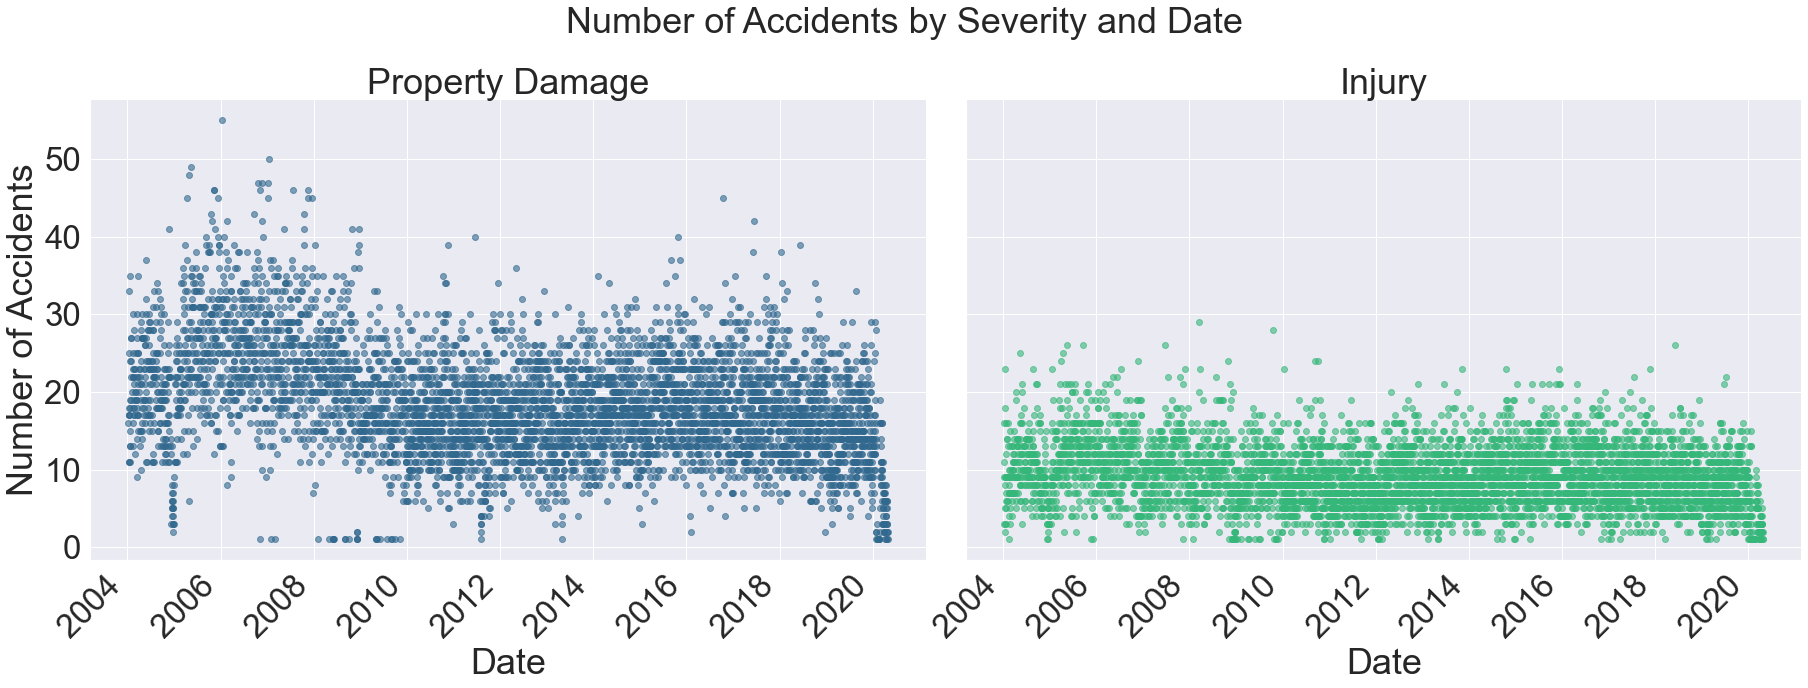

In [15]:
seattle_scatter(accidents_filtered,
                "DATE",
                "Date")

In [16]:
date_count_df = accidents_filtered["DATE"].value_counts().to_frame().reset_index().rename(columns = {"index": "Date",
                                                                                                     "DATE": "Count"})
date_count_df['Date'] = date_count_df['Date'].astype(str).apply(lambda d: d[0:10])

### i. Dates with the greatest number of accidents

In [17]:
date_count_df[:10].transpose()

0           1           2           3           4           5  \
Date   2006-01-13  2005-05-18  2005-04-15  2005-04-29  2007-07-20  2007-11-15   
Count          75          75          70          69          68          67   

                6           7           8           9  
Date   2006-11-22  2008-10-31  2018-06-08  2007-10-19  
Count          66          65          65          65

### ii. Dates with the fewest number of accidents

In [18]:
date_count_df[-10:].transpose()

5328        5329        5330        5331        5332        5333  \
Date   2009-04-09  2020-04-28  2007-11-09  2009-06-01  2009-02-09  2008-06-02   
Count           1           1           1           1           1           1   

             5334        5335        5336        5337  
Date   2008-06-04  2011-08-08  2009-04-03  2008-09-06  
Count           1           1           1           1

There seems to be slightly more accidents from 2005-2008 and slightly less from 2011-2013, but overall the variance seems to be within reason.


### iii. Day of Week

I explored whether the Day of Week seemed to affect the Severity Code Ratio.

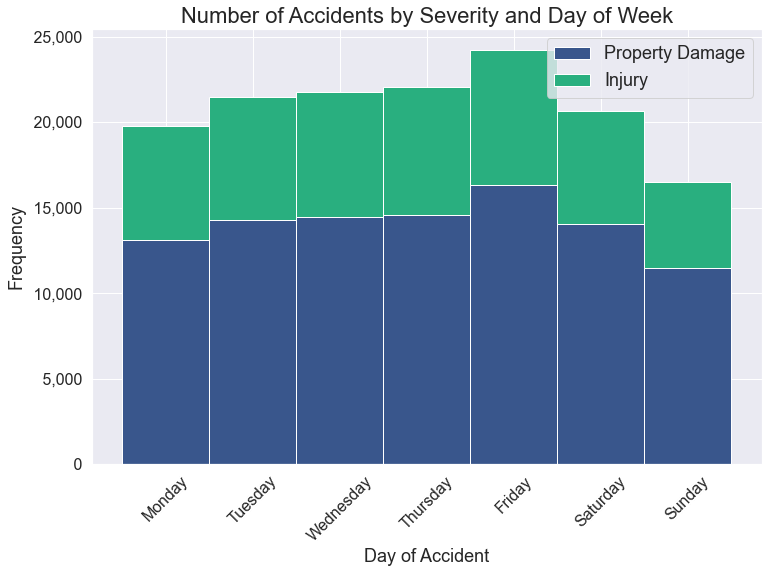

In [19]:
dow_df = pd.DataFrame(accidents_filtered[['SEVERITYCODE', 'DATE']])
dow_df['Day'] = dow_df['DATE'].dt.dayofweek
dow_df.drop("DATE", axis = 1, inplace = True)

bins = np.arange(8)-0.5

days = ['Monday', 'Tuesday', 'Wednesday',
        'Thursday', 'Friday',
        'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize = (12, 8))
ax.hist([dow_df[dow_df['SEVERITYCODE'] == 1]['Day'],
         dow_df[dow_df['SEVERITYCODE'] == 2]['Day']],
        bins = bins,
        color = ['#39568CFF', '#29AF7FFF'],
        label = ['Property Damage', 'Injury'],
        stacked = True);


ax.set_title("Number of Accidents by Severity and Day of Week", fontsize = 22)
ax.set_xlabel(xlabel = 'Day of Accident' , fontsize = 18)
plt.xticks(ticks = [0,1,2,3,4,5,6], labels = days, ha = 'center', rotation = 45)
ax.set_ylabel(ylabel = "Frequency", fontsize = 18)
ax.yaxis.set_major_formatter(SMF('{x: ,.0f}'))
ax.tick_params(axis = 'both', labelsize = 16)
ax.legend(fontsize = 18, loc = 'upper right');


While there are definitely more accidents on Friday (perhaps stressed from the work week, perhaps more traveling for longer periods for the weekend) and fewer on Sunday (perhaps more relax at home), the ratio of Property Damage to Injury by day reflects the overall ratio of 2:1.

## 4. Time

If accidents were uniformly distributed across time of day, there would be approximately 102 accidents per minute.


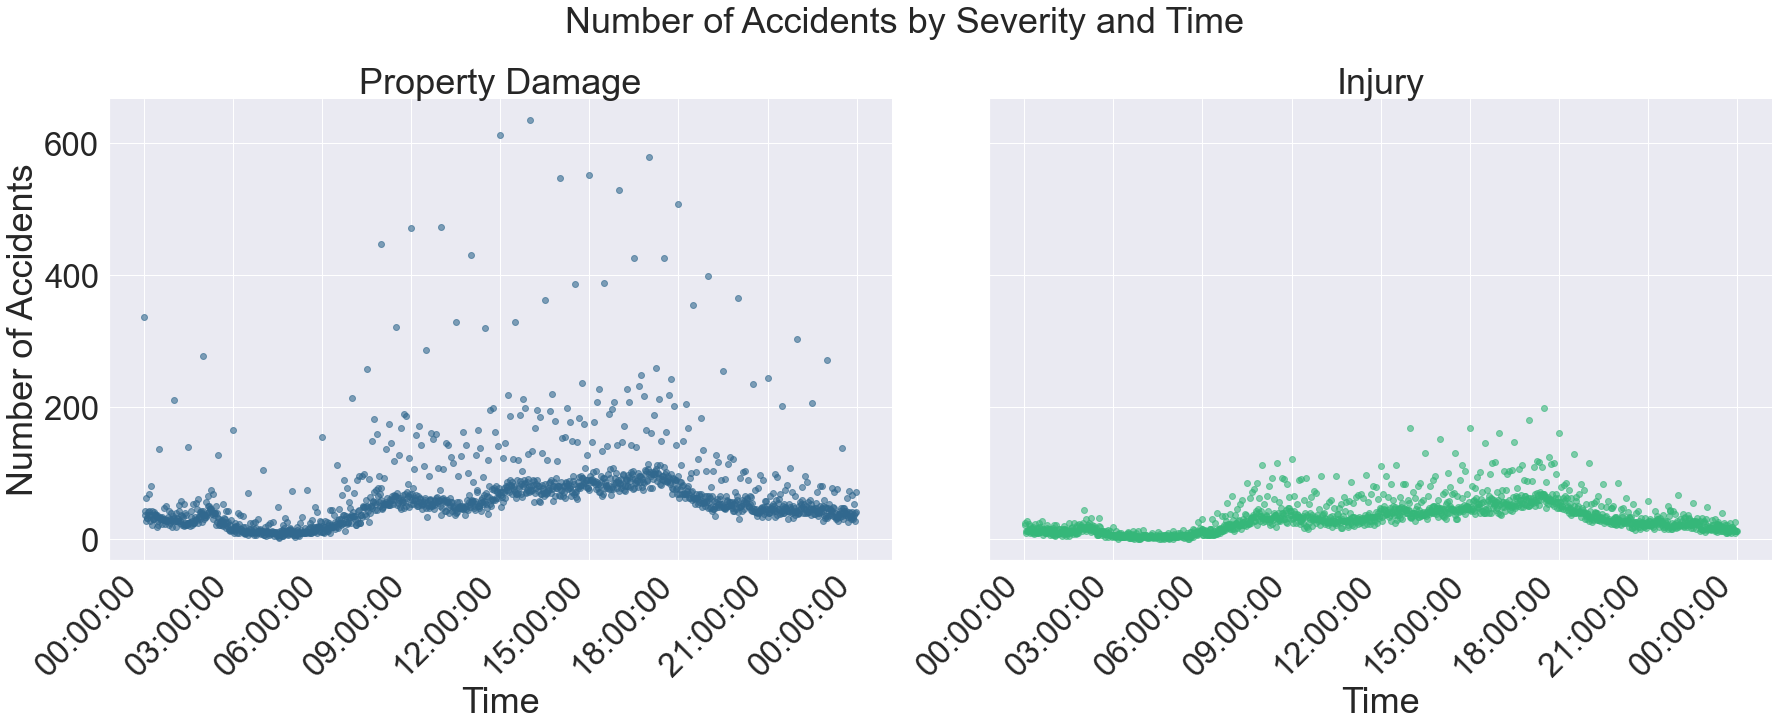

In [20]:
print("If accidents were uniformly distributed across time of day, there would be approximately",
      round(final / (24*60)), "accidents per minute.")

seattle_scatter(accidents_filtered,
                "TIME",
                "Time")

In [21]:
time_count_df = accidents_filtered["TIME"].value_counts().to_frame().reset_index().rename(columns = {"index": "Time",
                                                                                                     "TIME": "Count"})
time_count_df['Time'] = time_count_df['Time'].astype(str).apply(lambda d: d[11:19])

time_count_df["Min"] = time_count_df['Time'].apply(lambda x: str(x)[3:5])



#Output function.
def list_times(df, minutes, limit):
    return(df[df["Min"].isin(minutes)][["Time", "Count"]].transpose().loc[:, 0:limit])

### i. Times on the hour

In [22]:
list_times(time_count_df, ["00"], 38)

0         1         2         3         4         5         6   \
Time   13:00:00  17:00:00  12:00:00  15:00:00  14:00:00  16:00:00  18:00:00   
Count       804       759       722       720       699       690       669   

             8         10        11        14        15        18        25  \
Time   09:00:00  10:00:00  08:00:00  11:00:00  19:00:00  20:00:00  22:00:00   
Count       593       568       560       516       513       450       370   

             38  
Time   02:00:00  
Count       321

### i. Times on the half hour

In [23]:
list_times(time_count_df, ["30"], 69)

7         9         12        13        16        17        19  \
Time   17:30:00  16:30:00  15:30:00  14:30:00  13:30:00  18:30:00  12:30:00   
Count       624       572       533       517       492       484       441   

             20        21        22        23        30        33        51  \
Time   08:30:00  10:30:00  11:30:00  09:30:00  07:30:00  19:30:00  20:30:00   
Count       436       425       416       380       343       339       289   

             69  
Time   22:30:00  
Count       261

### iii. Times on the quarter hour

In [24]:
list_times(time_count_df, ["15", "45"], 59)

24        27        28        29        36        41        43  \
Time   17:15:00  16:45:00  17:45:00  14:45:00  16:15:00  15:45:00  13:45:00   
Count       377       361       357       349       327       313       310   

             45        47        49        50        54        55        57  \
Time   15:15:00  14:15:00  12:45:00  18:15:00  12:15:00  08:45:00  11:45:00   
Count       302       299       295       290       282       281       278   

             59  
Time   13:15:00  
Count       277

### iv. Times every ten minutes

In [25]:
list_times(time_count_df, ["10", "20", "40", "50"], 62)

31        32        34        35        37        40        42  \
Time   17:40:00  16:40:00  17:20:00  15:20:00  15:50:00  17:50:00  16:20:00   
Count       342       339       329       329       324       317       312   

             44        48        52        53        58        60        61  \
Time   16:50:00  17:10:00  15:40:00  12:50:00  14:50:00  13:40:00  16:10:00   
Count       306       297       289       283       277       275       275   

             62  
Time   13:50:00  
Count       274

### iv. Times every five minutes

In [26]:
list_times(time_count_df, ["05", "25", "35", "55"], 111)

72        77        79        80        81        86        95   \
Time   17:25:00  16:55:00  17:35:00  17:05:00  16:25:00  17:55:00  15:05:00   
Count       258       253       250       249       248       240       228   

            101       102       103       104       105       106       107  \
Time   16:05:00  14:05:00  16:35:00  14:25:00  15:35:00  15:55:00  14:35:00   
Count       221       221       218       217       216       215       212   

            111  
Time   13:05:00  
Count       205

### v. Times with the fewest number of accidents

In [27]:
time_count_df[["Time", "Count"]][1423:1438].transpose()

1423      1424      1425      1426      1427      1428      1429  \
Time   04:13:00  05:13:00  04:29:00  03:56:00  05:08:00  04:31:00  03:46:00   
Count        10        10        10        10         9         9         9   

           1430      1431      1432      1433      1434      1435      1436  \
Time   03:31:00  04:52:00  04:32:00  04:22:00  04:51:00  05:06:00  04:41:00   
Count         9         9         9         8         8         8         8   

           1437  
Time   05:01:00  
Count         7

### vi. 00:01:00!!!!!

In [28]:
list_times(time_count_df, ["01"], 26)

26
Time   00:01:00
Count       361

It is clear that the majority of accidents happen in the business, lunch, and daylight hours of 8:00 - 18:00.

There seems to be a disproportionate number of accidents reported on, in decreasing order:

<ul>
  <li>Every hour, particularly between 12:00 - 18:00.</li>
  <li>Every half hour, particularly between 12:30 - 18:30</li>
  <li>Every quarter hour.</li>
  <li>Every :10, :20, :40, and :50.</li>
  <li>Every :05, :25, :35, and :55.</li>
</ul>

Lastly, there was a disproportionate spike at 00:01:00, which means accidents being purposely documented to the next day was not uncommon.  I found this extremely fascinating, perhaps for bureaucratic reasons, quotas, night shift, etc.  Upon further investigation, I learned these times did not coincide with specific dates such as 1st of a month. 


## 5. Address Type

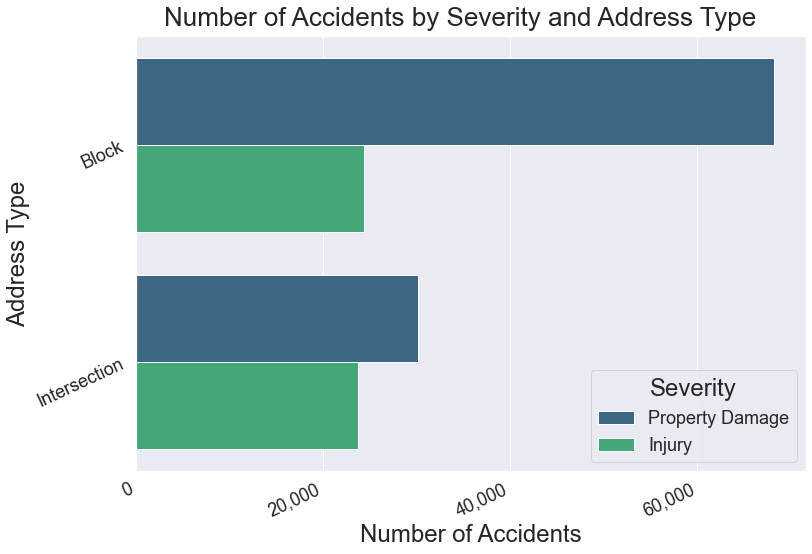

In [29]:
seattle_histogram(accidents_filtered, 'ADDRTYPE', "Address Type")

The majority of property damage occurs on blocks, but injury occurs about equally between blocks and intersections.

Intersections are usually larger and have more road space and less businesses and buildings compared to blocks.

This variable is the only one where the ratio of of Property Damage to Injury did not reflect the overall ratio of 2:1.

## 6. Light Conditions

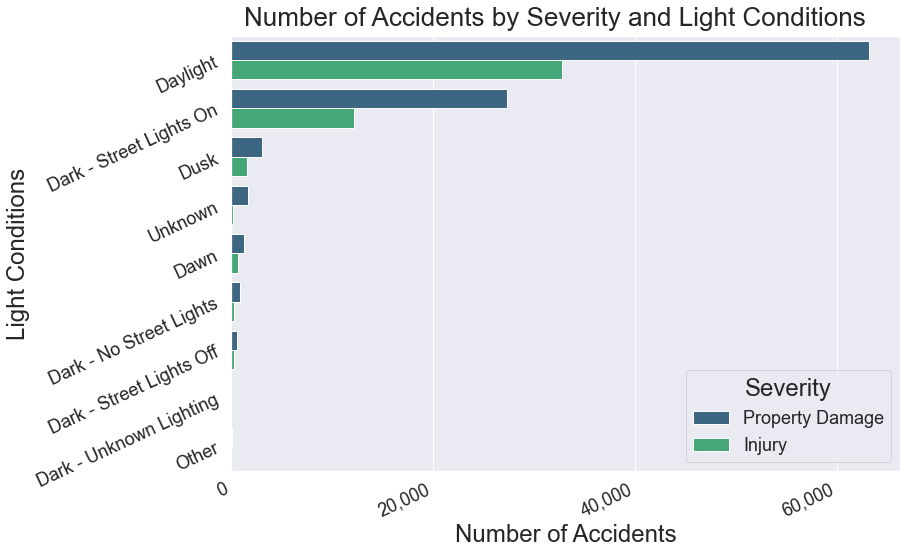

In [30]:
seattle_histogram(accidents_filtered, 'LIGHTCOND', "Light Conditions")

The vast majority of accidents occur during *Daylight* and *Dark - Street Lights On*.  The values of Property Damage and Injury reflect the overall ratio of 2:1.

## 7. Road Conditions

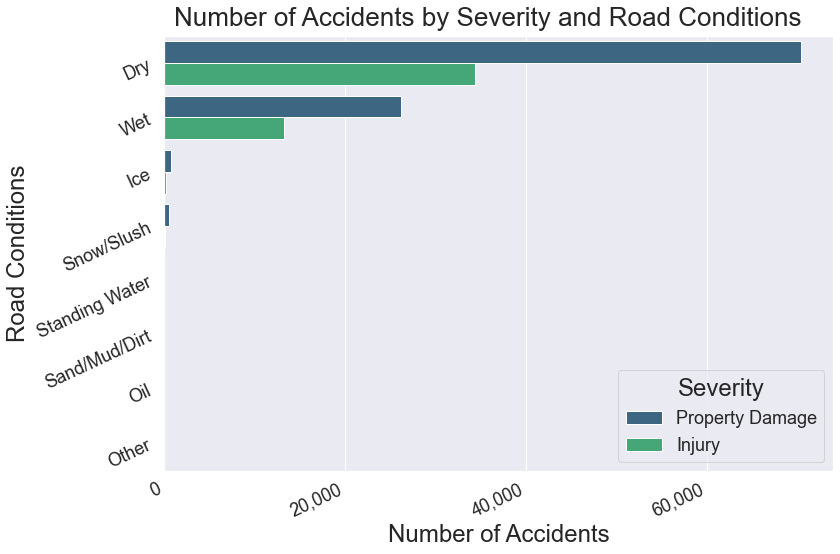

In [31]:
seattle_histogram(accidents_filtered, 'ROADCOND', "Road Conditions")

The vast majority of accidents occur during *Dry* and *Wet*.  The values of Property Damage and Injury reflect the overall ratio of 2:1.

## 8. Weather Conditions

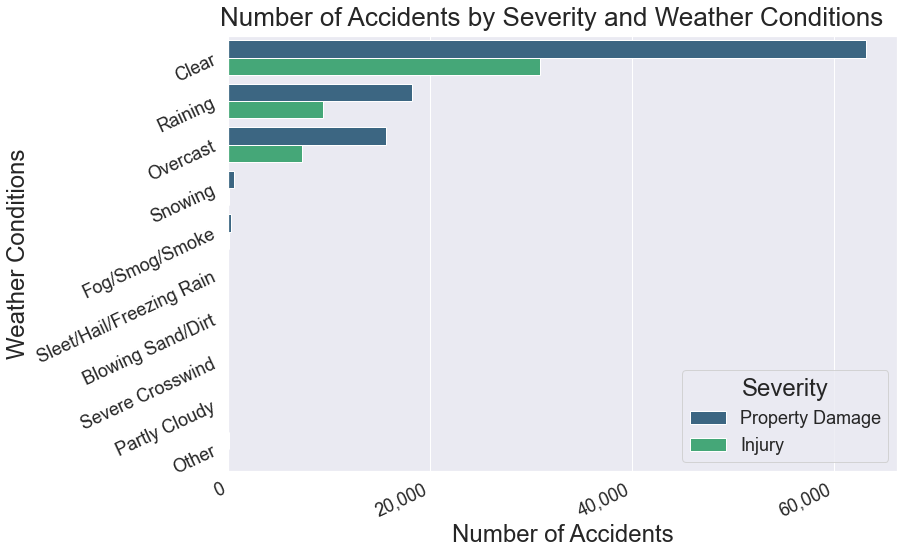

In [32]:
seattle_histogram(accidents_filtered, 'WEATHER', "Weather Conditions")

The overwhelming majority of accidents occur during *Clear*, *Raining*, and *Overcast*. The values of Property Damage and Injury reflect the overall ratio of 2:1.

# V. Final Feature Selection and Setup

## 1. Convert Date and Time

Date and Time are converted to integers for regression.

In [33]:
accidents_final = accidents_filtered.copy(deep = True)

accidents_final["DATE"] = accidents_final["DATE"].apply(lambda d: d.toordinal())

#Returns integer number of minutes from datetime
def get_minutes(time) :
    temp = str(time)
    hour = int(temp[11:13])
    minute = int(temp[14:16])
    return(hour*60 + minute)

accidents_final["TIME"] = accidents_final["TIME"].apply(lambda t : get_minutes(t))

## 2. Specify *Other* label

The following predictors have an other label.  They will be appropriately clarified.
<ul>
  <li>Light Condition</li>
  <li>Road Condition</li>
  <li>Weather Condition</li>
</ul>

This differentiation will be important for the upcoming dummy variables.

In [34]:
#Helper function to specify Other.
def change_other(df, column, label) :
    df.loc[df[column] == 'Other', column] = label
    

#Light Condition.
change_other(accidents_final, 'LIGHTCOND', 'Other_L')
#Road Condition.
change_other(accidents_final, 'ROADCOND', 'Other_R')
#Weather Condition.
change_other(accidents_final, 'WEATHER', 'Other_W')

## 3. Create Dummy Variables for:

<ul>
  <li>Address Type</li>
  <li>Light Condition</li>
  <li>Road Condition</li>
  <li>Weather Condition</li>
</ul>

In [35]:
categoricals = ['ADDRTYPE', 'LIGHTCOND',
                'ROADCOND', 'WEATHER']

def dummies(df, categoricals) :
    for var in categoricals:
        df = pd.concat([df, pd.get_dummies(df[var])], axis = 1)
        df.drop([var], axis = 1, inplace = True)
    return(df)

accidents_final = dummies(accidents_final, categoricals)

## 4. Time and Light Condition Correlation

It occurred to me that Time and Light Condition are very likely to be highly correlated based on the frequency and preliminary summaries from my EDA.  I decided to explore these further.

In [36]:
#Helper function
def time_light(df, light):

    return [df[df["TIME"] < 720][["TIME", light]].corr().iloc[0,1],
            df[df["TIME"] >= 720][["TIME", light]].corr().iloc[0,1]]



#Daylight - [AM, PM]. 
daylight = time_light(accidents_final, "Daylight")

#Dark - Street Lights On - [AM, PM]. 
dark = time_light(accidents_final, "Dark - Street Lights On")

#Summarize correlations.
data = {"Daylight" : daylight,
        "Dark - Street Lights On" : dark,
        "":["AM", "PM"]}
df = pd.DataFrame(data).set_index("")
df.style.set_caption("Time and Light Condition Correlation")

In [37]:
#Helper function
def road_weather(df, weather):

    return [df[["Dry", weather]].corr().iloc[0,1],
            df[["Wet", weather]].corr().iloc[0,1]]



#Clear - [Dry, Wet]. 
clear = road_weather(accidents_final, "Clear")

#Raining - [Dry, Wet]. 
raining = road_weather(accidents_final, "Raining")

#Summarize correlations.
data = {"Clear" : clear,
        "Raining" : raining,
        "":["Dry", "Wet"]}
df = pd.DataFrame(data).set_index("")
df.style.set_caption(" Road and Weather Condition Correlation")

*Dry/Wet* from Road Condition and *Clear/Raining* from Weather Condition are appropriately correlated as expected.  However, they are not so strong to be considered collinear.  No variables will be removed.

## 6. Default Values

The following are the category labels that contain the overwhelming majority of observations from their respective original variables.  They will be set as default and the corresponding dummy column will be dropped.

<ul>
    <li><i>Block</i> from Address Type</li>
    <li><i>Daylight</i> from Light Condition</li>
    <li><i>Dry</i> from Road Condition</li>
    <li><i>Clear</i> from Weather Condition</li>
</ul>

In [38]:
labels = ['Block', 'Daylight',
          'Dry', 'Clear']

for label in labels :
    accidents_final.drop([label], axis = 1, inplace = True)

## 7. Final Predictors

<ul>
    <li>X, Y, DATE, and TIME are scaled.  The rest of the predictors are binary derived from categories.</li>
    <li>Severity Code will be separated as the outcome variable (saved as an array).</li>
    <li>The data will be split into training (70%) and test (30%) sets.</li>
    <li>For one training/test set, Latitude and Longitude will be kept for location, Neighborhood will be dropped.</li>
    <li>For the other training/test set, Neighborhood will be kept for location, Latitude and Longitude will be dropped.  In addition, <i>Industrial District</i> will be set as the default value and the column will be dropped.</li>

In [39]:
#Helper.
def location_creator(df, location):
    #Latitude and Longitude for location.
    if location == 'll':
        df = df.drop(['NEIGHBORHOOD'], axis = 1)
    #Neighborhood for location.
    else :
        df = dummies(df.drop(['X', 'Y'], axis = 1), ['NEIGHBORHOOD']).drop(['Industrial District'], axis = 1)
    
    return(df)



#Scale Columns.
for column in ['X', 'Y', 'DATE', 'TIME']:
    accidents_final[column] = (accidents_final[column] - accidents_final[column].min()) / accidents_final[column].max()

#Outcome variable.
y = accidents_final["SEVERITYCODE"].values - 1
accidents_final.drop("SEVERITYCODE", axis = 1, inplace = True)

#Test Train Split.
from sklearn.model_selection import train_test_split as TTS
X_train, X_test, y_train, y_test = TTS(accidents_final, y, test_size = 0.3, random_state = 13131)

#Latitude and Longitude for location.
X_ll_train = location_creator(X_train, 'll')
X_ll_test = location_creator(X_test, 'll')

#Neighborhood for location.
X_hood_train = location_creator(X_train, 'hood')
X_hood_test = location_creator(X_test, 'hood')

# VI.  Classification Models

I am using four machine learning algorithms:

<ul>
    <li>Decision Tree (Random Forest)</li>
    <li>K-Nearest Neighbors</li>
    <li>Logistic Regression</li>
    <li>Support Vector Machine (LinearSVC with Ridge)</li>
</ul>

Each model will be run in a validation curve simulation to optimize its respective parameter/hyperparameter.  In addition, each model will be run for both the *Latitude/Longitude* and *Neighborhood* training sets.

## 1. Function

In [40]:
from sklearn.model_selection import validation_curve as VC

#Graphs Validation Curve of Train and Validation Sets given a model, X, y, and name of model.
def model_vc(model, X, y, name):
    
    #Random Forest.
    if (name == "Random Forest"):
        param_name = "max_depth"
        param_range = list(range(5, 11))
        proper = "Maximum Depth"
    
    #K-Nearest Neighbor.
    elif name == "K-Nearest Neighbor":
        param_name = "n_neighbors"
        param_range = [5, 10, 15, 20, 25,
                       30, 35, 40, 45, 50,
                       100, 150, 200, 250,
                       300, 350, 400, 450,
                       500]
        proper = "# of Neighbors"
    
    #SVM and Logistic Regression.
    else:
        param_name = "C"
        param_range = [10**n for n in range(-7, 2)]
        proper = "C"
    
    #Validation Curve with 5-fold.
    train_scores, valid_scores = VC(model,
                                    X,
                                    y,
                                    param_name = param_name ,
                                    param_range = param_range,
                                    cv = 5)
    
    #Get Accuracies.
    train_list = []
    valid_list = []
    for p in range(len(param_range)) :
        train_list.append(sum(train_scores[p]) / 5)
        valid_list.append(sum(valid_scores[p]) / 5)
    
    #Plot.
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.plot(param_range, train_list, c = 'b', lw = 3, label = "Train Set")
    ax.plot(param_range, valid_list, c = 'g', lw = 3, label = "Validation Set")
    #Title.
    ax.set_title("Train and Validation Set Accuracies of " + name + " by " + proper, fontsize = 22)

    #X-Axis.
    ax.set_xlabel(xlabel = proper, fontsize = 18)
    if (name == "Random Forest"):
        ax.set_xticks(param_range)
    elif (name == "K-Nearest Neighbor"):
        ax.set_xticks([50*x for x in range(11)])
    else:    
        ax.set_xscale('log')
        proper = "Hyperparameter C Value"
    ax.set_xlabel(xlabel = proper, fontsize = 18)        

    #Y-Axis.
    ax.set_ylabel(ylabel = "Accuracy", fontsize = 18)
    ax.yaxis.set_major_formatter(SMF('{x: 0.5f}'))
    ax.tick_params(axis = 'both', labelsize = 16)
    
    #Legend and Footnote.
    ax.legend(fontsize = 18, loc = 'center right')
    plt.figtext(0.9, 0, "5-fold cross-validation values were averaged.", ha = 'right', fontsize = 12);

## 2. Decision Tree (Random Forest)

### i. Setup

50 decision trees using a maximum depth of 5 to 10 will be evaluated to determine the best fit.

In [41]:
from sklearn.ensemble import RandomForestClassifier as RFC

model = RFC(n_estimators = 50,
            random_state = 13131)

### ii. Latitude and Longitude

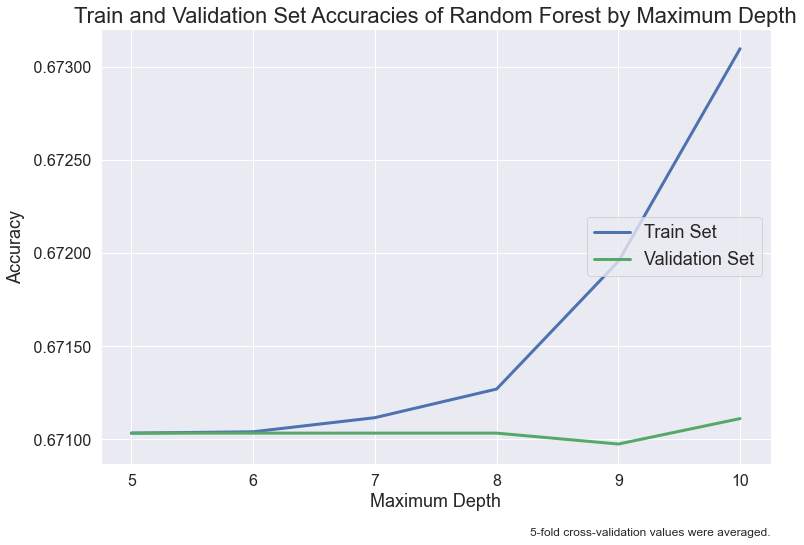

In [42]:
model_vc(model, X_ll_train, y_train, "Random Forest")

A depth of maxium depth of 6 will be used.

In [43]:
dtrf_ll_model = RFC(n_estimators = 50,
                    max_depth = 6,
                    random_state = 13131).fit(X_ll_train, y_train)

### iii. Neighborhoods

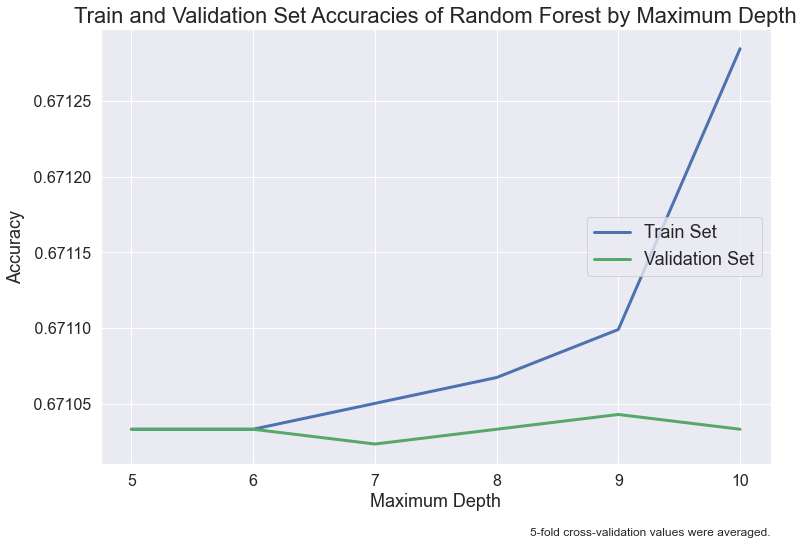

In [44]:
model_vc(model, X_hood_train, y_train, "Random Forest")

A depth of maxium depth of 6 will be used.

In [45]:
dtrf_hood_model = RFC(n_estimators = 50,
                      max_depth = 6,
                      random_state = 13131).fit(X_hood_train, y_train)

## 3. K Nearest Neighbors

### i. Setup

K-Nearest Neighbors.  Select values of Number of Neighbors from $1$ to $500$ will be evaluated to determine the best fit.

Due to the nature of the data and the complexity of the algorithm, *KNN* required much more time and resource processes than the entire rest of the analysis.

Hence, the select values were 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500.

In [46]:
from sklearn.neighbors import KNeighborsClassifier as KNC

model = KNC(algorithm = 'ball_tree', leaf_size = 5000, n_jobs = -1)

### ii. Latitude and Longitude

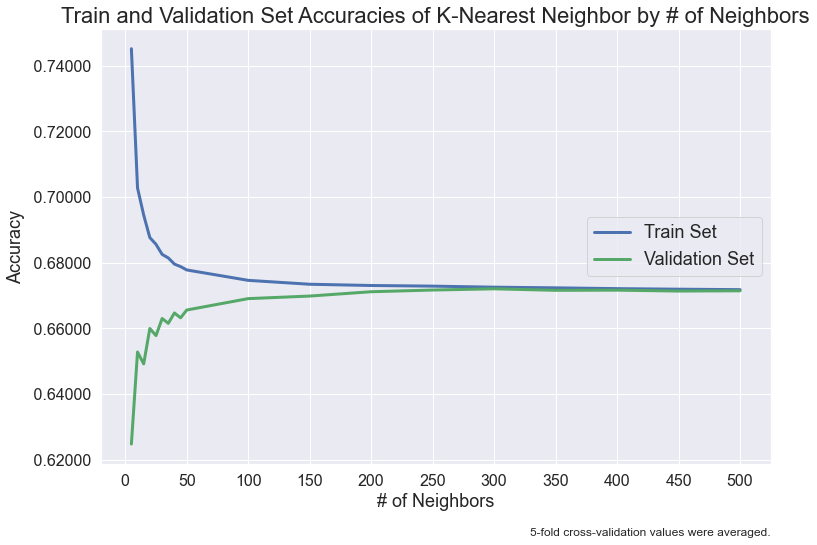

In [47]:
model_vc(model, X_ll_train, y_train, "K-Nearest Neighbor")

$N = 500$ will be used.

In [48]:
knn_ll_model = KNC(algorithm = 'ball_tree',
                   leaf_size = 5000,
                   n_neighbors = 500,
                   n_jobs = -1).fit(X_ll_train, y_train)

### iii. Neighborhoods

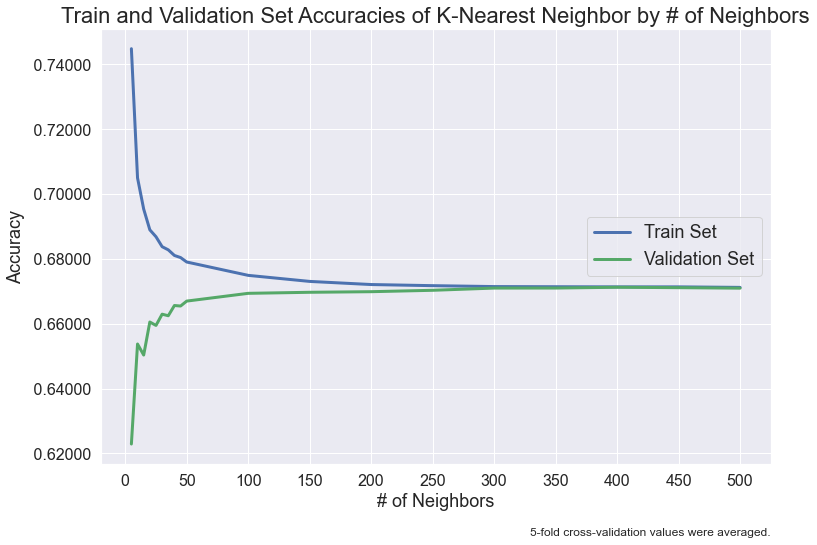

In [49]:
model_vc(model, X_hood_train, y_train, "K-Nearest Neighbor")

$N = 500$ will be used.

In [50]:
knn_hood_model = KNC(algorithm = 'ball_tree',
                     leaf_size = 5000,
                     n_neighbors = 500,
                     n_jobs = -1).fit(X_hood_train, y_train)

## 4. Logistic Regression

### i. Setup

A logistic regression will be used.  Hyperparameter $C$ values from $10^{-7}$ to $10^{1}$ will be evaluated to determine the best fit.

In [51]:
from sklearn.linear_model import LogisticRegression as LR

model = LR(max_iter = 1000, n_jobs = -1)

### ii. Latitude and Longitude

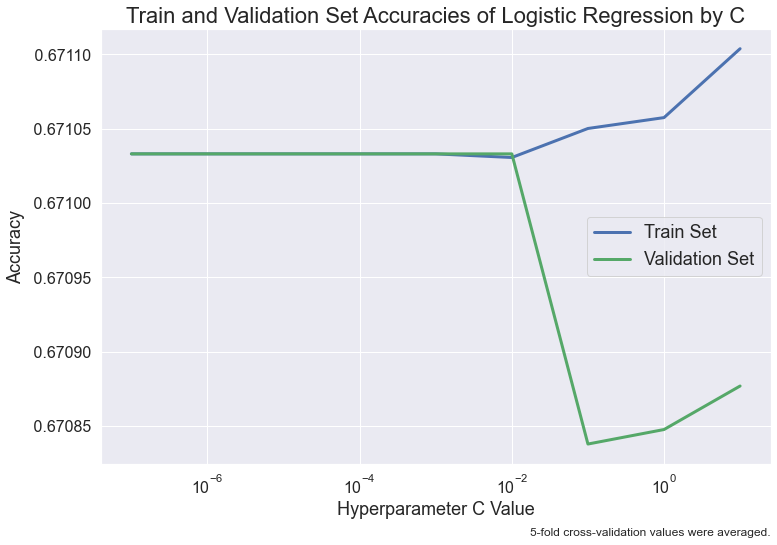

In [52]:
model_vc(model, X_ll_train, y_train, "Logistic Regression")

$C = 10^{-2}$ will be used.

In [53]:
lr_ll_model = LR(C = 1e-2).fit(X_ll_train, y_train)

### iii. Neighborhoods

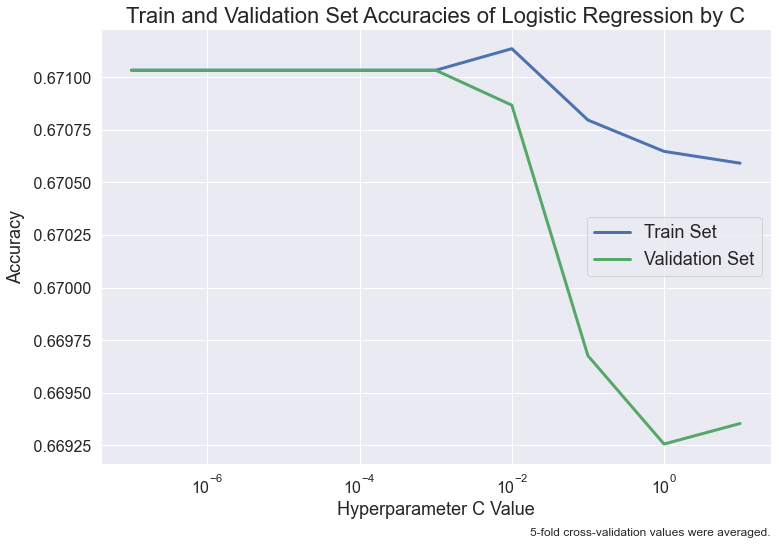

In [54]:
model_vc(model, X_hood_train, y_train, "Logistic Regression")

$C = 10^{-3}$ will be used.

In [55]:
lr_hood_model = LR(C = 1e-3).fit(X_hood_train, y_train)

## 5. Support Vector Machine

### i. Setup

A linear support vector classifier with $L2$ penalty will be used.  Hyperparameter $C$ values from $10^{-7}$ to $10^{1}$ will be evaluated to determine the best fit.

In [56]:
from sklearn.svm import LinearSVC as LSVC

model = LSVC(penalty = 'l2',
             random_state = 13131,
             dual = False,
             max_iter = 20000)

### ii. Latitude and Longitude

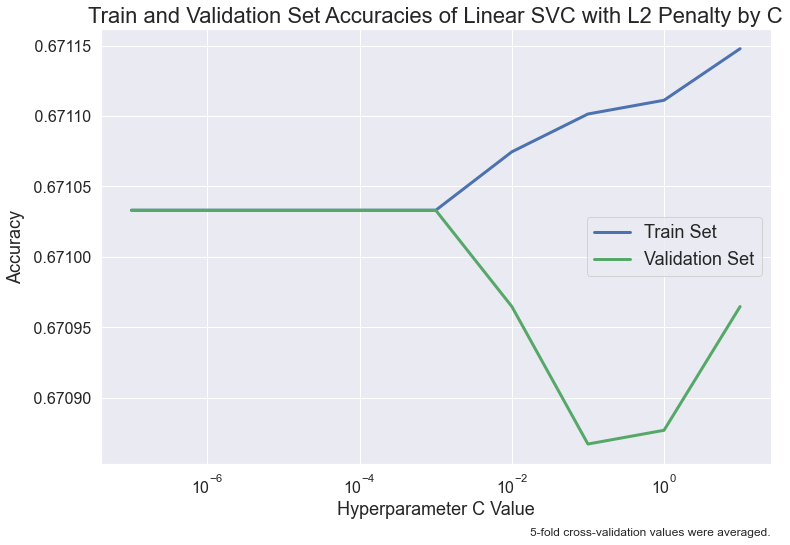

In [57]:
model_vc(model, X_ll_train, y_train, "Linear SVC with L2 Penalty")

$C = 10^{-3}$ will be used.

In [58]:
svm_ll_model = LSVC(penalty = 'l2',
                    C = 1e-3,
                    random_state = 13131,
                    dual = False,
                    max_iter = 10000).fit(X_ll_train, y_train)

### iii. Neighborhoods

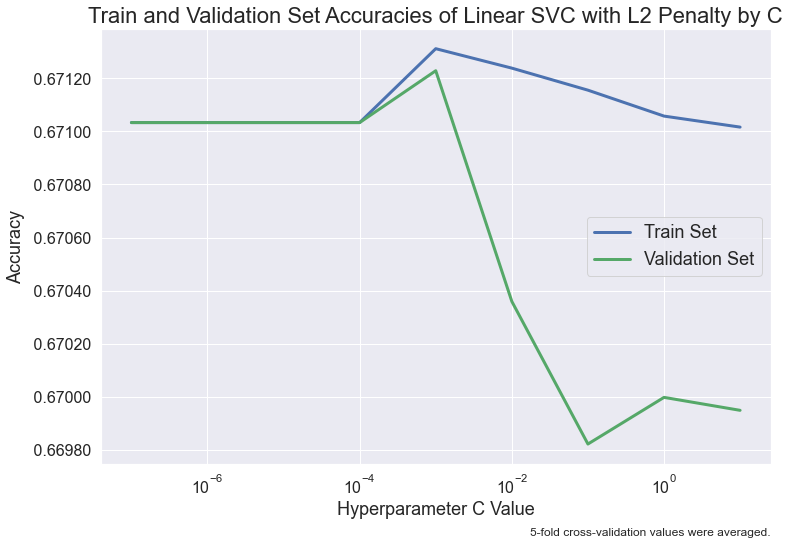

In [59]:
model_vc(model, X_hood_train, y_train, "Linear SVC with L2 Penalty")

$C = 10^{-3}$ will be used.

In [60]:
svm_hood_model = LSVC(penalty = 'l2',
                      C = 1e-3,
                      random_state = 13131,
                      dual = False,
                      max_iter = 10000).fit(X_hood_train, y_train)

# IV. Results

## 1. Function

In [61]:
from sklearn import metrics
from sklearn.metrics import jaccard_score as js
from sklearn.metrics import f1_score as fs
from sklearn.metrics import log_loss as lol

#Returns the Jaccard and F1 score, as well as Log Loss for the algorithms.
def summary(Xs, y):
    #Initialize lists.
    models = [dtrf_ll_model, dtrf_hood_model,
              knn_ll_model, knn_hood_model,
              lr_ll_model, lr_hood_model,
              svm_ll_model, svm_hood_model]
    jaccard = []
    f1s = []
    log_loss = ["NA", "NA", "NA", "NA"]
    
    #Calculate scores from each model and append to lists.
    for m in list(range(8)) :
        model = models[m]
        X = Xs[m%2]
        y_pred = model.predict(X)
        jaccard.append(js(y, y_pred, average = 'micro'))
        f1s.append(fs(y, y_pred, average = 'micro'))
        if (model in [lr_ll_model, lr_hood_model]) :
            log_loss.append(lol(y, model.predict_proba(X)))

    log_loss = log_loss +  ["NA", "NA"]
            
    #Names.
    dtrf = "Decision Tree/Random Forest"
    knn = "K-Nearest Neighbor"
    lr = "Logistic Regression"
    svm = "Support Vector Machine"
    ll = " (Latitude/Longitude)"
    n = " (Neighborhood)"
    
    #Output dataframe.
    data = {"Algorithm": [dtrf + ll, dtrf + n,
                          knn + ll, knn + n,
                          lr + ll, lr + n,
                          svm + ll, svm + n],
            "Jaccard": jaccard,
            "F1-Score": f1s,
            "Log Loss": log_loss}
       
    report = pd.DataFrame(data = data).set_index("Algorithm")
    return(report)

## 2. Train Set Results

In [62]:
summary([X_ll_train, X_hood_train], y_train)

Jaccard  F1-Score  Log Loss
Algorithm                                                                     
Decision Tree/Random Forest (Latitude/Longitude)  0.504928  0.671033        NA
Decision Tree/Random Forest (Neighborhood)        0.504928  0.671033        NA
K-Nearest Neighbor (Latitude/Longitude)           0.506079  0.672048        NA
K-Nearest Neighbor (Neighborhood)                 0.505183  0.671258        NA
Logistic Regression (Latitude/Longitude)          0.504928  0.671033  0.615137
Logistic Regression (Neighborhood)                0.504928  0.671033  0.615592
Support Vector Machine (Latitude/Longitude)       0.504928  0.671033        NA
Support Vector Machine (Neighborhood)             0.505161  0.671238        NA

## 3. Test Set Results

In [63]:
summary([X_ll_test, X_hood_test], y_test)

Jaccard  F1-Score  Log Loss
Algorithm                                                                     
Decision Tree/Random Forest (Latitude/Longitude)  0.506580  0.672490        NA
Decision Tree/Random Forest (Neighborhood)        0.506580  0.672490        NA
K-Nearest Neighbor (Latitude/Longitude)           0.506683  0.672581        NA
K-Nearest Neighbor (Neighborhood)                 0.506786  0.672672        NA
Logistic Regression (Latitude/Longitude)          0.506580  0.672490  0.613581
Logistic Regression (Neighborhood)                0.506580  0.672490  0.614233
Support Vector Machine (Latitude/Longitude)       0.506580  0.672490        NA
Support Vector Machine (Neighborhood)             0.506709  0.672603        NA

# V. Discussion and Conclusion

Four models, using two different location measures, were evaluated on the training set and test set.  Note that all 16 results are within 67.1-67.3%.  I could not immediately see a significance in the difference between Latitude/Longitude or the Neighborhoods.  Neighborhoods did take longer to run in general, as about 90 dummy variables were added to categorize all neighborhoods with non-zero accident counts.

Using Neighborhood as the location predictor, K-Nearest Neighbors at 500 Neighbors and a Linear Support Vector Classifier applying a L2 penalty yielded 67.27% and 67.26% accuracy.  The SVM took less than 30 seconds, whereas the KNN took several hours. 

Since Property Damage and Injury occur approximately $\dfrac{2}{3}$ and $\dfrac{1}{3}$ of the time, randomly classifying Property Damage $\dfrac{2}{3}$ the time and Injury $\dfrac{1}{3}$ the time would yield an accuracy of $\left(\dfrac{2}{3}\right)^2+ \left(\dfrac{1}{3}\right)^2 = \dfrac{5}{9} \approx 55.6\%$.  The learned model seemed to be a significant improvement from that. 

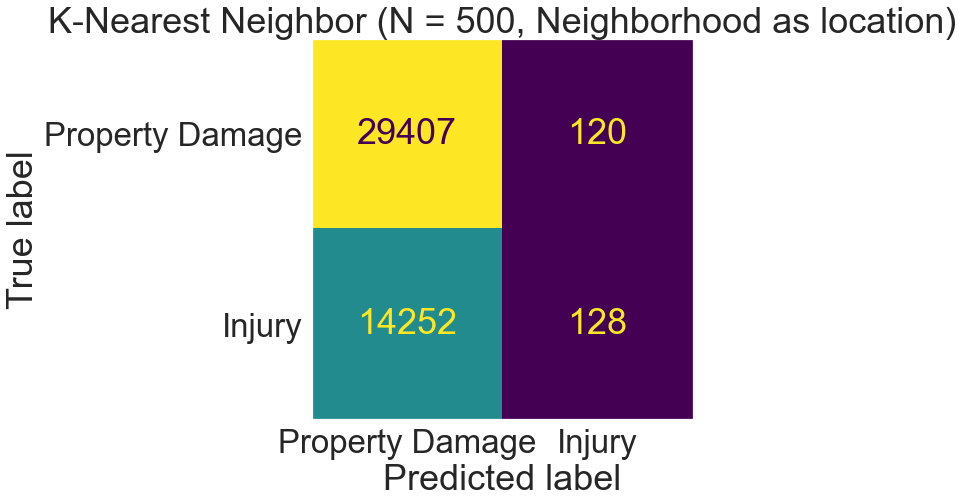

In [64]:
from sklearn.metrics import plot_confusion_matrix as PCM

PCM(estimator = knn_hood_model,
    X = X_hood_test,
    y_true = y_test,
    display_labels = ("Property Damage", "Injury"),
    include_values = True)
plt.gcf().set_size_inches(10, 7)
plt.gca().images[-1].colorbar.remove()
plt.gca().grid(False)
plt.title(label = "K-Nearest Neighbor (N = 500, Neighborhood as location)")
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12)


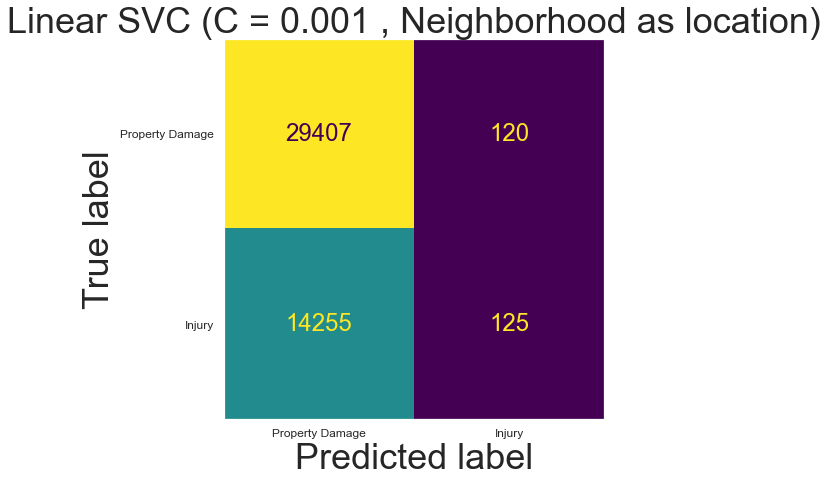

In [66]:
PCM(estimator = svm_hood_model,
    X = X_hood_test,
    y_true = y_test,
    display_labels = ("Property Damage", "Injury"),
    include_values = True)
plt.gcf().set_size_inches(10, 7)
plt.gca().images[-1].colorbar.remove()
plt.gca().grid(False)
plt.title(label = "Linear SVC (C = 0.001 , Neighborhood as location)")
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12)

My best algorithms are ~67% accurate because they are classifying accidents as Property Damage ~99% of the time, and ~67% of accidents happen to be Property Damage!

The predictors I used were immediate predictors related to the scene and setting of an accident.  Some other predictors, perhaps, number of cars, pedestrians, speeding, under the influence, etc., could possibly be useful and improve accuracy, but require more time to gather details.  In addition, if one were at the scene of the accident gathering those variables, one could easily determine if there were Property Damage or Injury. Prediction then becomes unnecessary because one can simply document the result at the scene.   

It seems to me that accidents in general should be predicted to be "Property Damage" twice as often as "Injury", and thus resource planning be allocated appropriately.  The dataset did not specify accidents which had both, which has to have a significant occurrence.

Note that using *Block/Intersection* alone yields 67.25% accuracy!

In [67]:
Xloc_train = X_train[['Intersection']]
Xloc_test = X_test[['Intersection']]

lrloc = LR(C = 1e-3).fit(Xloc_train, y_train)

fs(y_test, lrloc.predict(Xloc_test), average = 'micro')

0.672489580249163

## Note

I wanted to explore accidents that are documented at 00:01, as there was significant overrepresentation.  There does not appear to be any pattern in the Date (specifically, I thought perhaps 1st of months).  It is extremely curious to me that many accidents are clearly documented to the next day.  

In [68]:
df_dt = accidents_filtered[accidents_filtered['TIME'] == accidents_filtered['TIME'].min()]["DATE"]
df_dt = df_dt.value_counts().to_frame().reset_index().rename(columns = {"index": "Date", "DATE": "Accident Count at 00:01"})
df_dt['Date'] = df_dt['Date'].apply(lambda d: str(d)[0:10])
df_dt

Date  Accident Count at 00:01
0    2008-12-19                        3
1    2007-01-13                        2
2    2007-12-30                        2
3    2009-07-10                        2
4    2005-05-16                        2
..          ...                      ...
330  2018-01-01                        1
331  2007-06-22                        1
332  2012-10-13                        1
333  2010-09-23                        1
334  2007-03-20                        1

[335 rows x 2 columns]